In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
import folium
from sklearn.preprocessing import StandardScaler
import stargazer
from plotnine import *

In [2]:
# Read in datasets
demo = pd.read_csv('income_demo_poverty_data/demo_data_acs_5yr_clean.csv')
med_inc = pd.read_csv('income_demo_poverty_data/median_income.csv')
poverty = pd.read_csv('income_demo_poverty_data/poverty_census_data_clean.csv')
zip_borough = pd.read_csv('historical/historical_pulled_3.23.csv')

In [3]:
demo.head()

,zip_code,total_pop,white_pop,blackl_pop,native_american_pop,asian_pop,hispanic_pop,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc
0,6390,125,117,0,0,0,4,0.936000,0.000000,0.000000,0.000000,0.032000
1,10001,24117,15677,1510,16,5377,3741,0.650039,0.062611,0.000663,0.222955,0.155119
2,10002,74479,23849,6635,724,31198,19554,0.320211,0.089086,0.009721,0.418883,0.262544
3,10003,53977,40681,3007,81,7812,4559,0.753673,0.055709,0.001501,0.144728,0.084462
4,10004,3335,2033,142,0,992,108,0.609595,0.042579,0.000000,0.297451,0.032384


In [3]:
# Reduce zip_borough to just zipcode and borough
zip_borough = zip_borough[['PostalCode', 'Borough']]

In [4]:
# Clean up data and remove duplicate rows
zip_borough = zip_borough.dropna()
zip_borough['PostalCode'] = zip_borough['PostalCode'].astype(int)
zip_borough.drop_duplicates(inplace = True)
zip_borough.head()

,PostalCode,Borough
3,10465,The Bronx
4,11363,Queens
7,10014,Manhattan
8,10301,Staten Island
9,10314,Staten Island


In [5]:
# Combine with demographic data
zip_borough.rename(columns = {'PostalCode':'zip_code'}, inplace = True)
demo = demo.merge(zip_borough, on='zip_code', how='inner')

In [6]:
# Create percent non-white field
demo['non_white_perc'] = 1 - demo['white_perc']

In [7]:
# Attaching median income data
demo = demo.merge(med_inc, on='zip_code', how='left')

In [8]:
# Roll up to the borough level
demo['families_median_income'][demo['families_median_income']=='250,000+']=250000
demo = demo[demo['families_median_income'] != '-']
demo['families_median_income'] = demo['families_median_income'].astype(float)
borough_demo = demo.groupby('Borough').agg({'total_pop':'sum', 'white_pop':'sum', 'blackl_pop':'sum', 
                                           'native_american_pop': 'sum', 'asian_pop': 'sum',
                                           'hispanic_pop': 'sum', 'white_perc': 'mean', 'black_perc': 'mean', 
                                           'native_american_perc': 'mean', 'asian_perc': 'mean', 
                                           'hispanic_perc': 'mean', 'non_white_perc': 'mean', 
                                           'families_median_income':'median'})

<ipython-input-8-0e0873db2420>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
borough_demo.head()

,total_pop,white_pop,blackl_pop,native_american_pop,asian_pop,hispanic_pop,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,non_white_perc,families_median_income
Borough,,,,,,,,,,,,,
Brooklyn,2531407,1102386,816054,8276,303170,482282,0.452263,0.304009,0.003517,0.117882,0.192501,0.547737,65968.0
Manhattan,1554695,877178,233818,5769,184326,403828,0.584510,0.145220,0.003077,0.129730,0.218991,0.415490,176972.0
Queens,1545037,515748,380867,7240,347793,439280,0.346502,0.259757,0.004415,0.210164,0.250918,0.653498,80690.5
Staten Island,474893,352034,48958,1026,44246,87576,0.727798,0.123341,0.002719,0.081395,0.203475,0.272202,95768.5
The Bronx,1137085,264375,422071,8205,47019,599873,0.288046,0.340591,0.006106,0.041120,0.493161,0.711954,55317.0


In [42]:
# Write to scv
borough_demo.to_csv('income_demo_poverty_data/borough_demo.csv')

In [11]:
# Convert zip_code to string for chloropleth map
demo['zip_code'] = demo['zip_code'].astype('str')

In [128]:
m = folium.Map(location=[40.75, -74.125])

folium.Choropleth(
    geo_data="nyczip.json",
    name='choropleth',
    data=demo,
    columns=['zip_code','families_median_income'],
    key_on='feature.properties.postalCode',
    fill_color='Oranges',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Median Income',
    zoom_start= 6.5
).add_to(m)

folium.LayerControl().add_to(m)

In [129]:
m

In [10]:
med_inc

,zip_code,families_median_income
0,6390,61125
1,10001,122776
2,10002,40045
3,10003,183787
4,10004,205202
...,...,...
1789,14898,55179
1790,14901,42036
1791,14903,81382
1792,14904,59597


In [11]:
borough_demo.reset_index(inplace = True)
borough_demo.head()

,Borough,total_pop,white_pop,blackl_pop,native_american_pop,asian_pop,hispanic_pop,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,non_white_perc,families_median_income
0,Brooklyn,2531407,1102386,816054,8276,303170,482282,0.452263,0.304009,0.003517,0.117882,0.192501,0.547737,65968.0
1,Manhattan,1554695,877178,233818,5769,184326,403828,0.584510,0.145220,0.003077,0.129730,0.218991,0.415490,176972.0
2,Queens,1545037,515748,380867,7240,347793,439280,0.346502,0.259757,0.004415,0.210164,0.250918,0.653498,80690.5
3,Staten Island,474893,352034,48958,1026,44246,87576,0.727798,0.123341,0.002719,0.081395,0.203475,0.272202,95768.5
4,The Bronx,1137085,264375,422071,8205,47019,599873,0.288046,0.340591,0.006106,0.041120,0.493161,0.711954,55317.0


In [12]:
b_melt = borough_demo.melt(id_vars = ['Borough'], value_vars = ['white_perc', 'black_perc', 
                                                                'asian_perc', 'hispanic_perc'])

In [13]:
b_melt.head()

,Borough,variable,value
0,Brooklyn,white_perc,0.452263
1,Manhattan,white_perc,0.584510
2,Queens,white_perc,0.346502
3,Staten Island,white_perc,0.727798
4,The Bronx,white_perc,0.288046


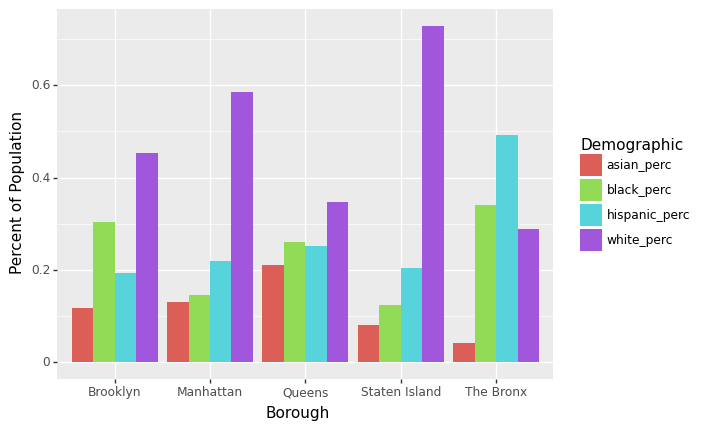

<ggplot: (8780598275118)>

In [14]:
ggplot(b_melt, aes('Borough', 'value')) + \
geom_bar(aes(fill = 'variable'), position = "dodge", stat="identity") + \
ylab('Percent of Population') + labs(fill = 'Demographic')

In [19]:
from plotnine import *

In [14]:
# Loading in outage data
outages = pd.read_csv('historical/historical_pulled_9.21.csv')

In [16]:
outages.head()

,GoogleMapsAddress,TimeCrawled,PostalCode,Latitude,Longitude,StreetNumber,StreetAddress,Neighborhood,Borough,County,...,CurrentOverallRanking,PlaceID,OutageCustomers,Problem,CrewStatus,Cause,UniqueID,DateCrawled,TimeStampCrawled,DateFixed
0,5019 SKILLMAN AV,01:33:29,11377.0,40.746228,-73.913521,50-19,Skillman Avenue,Flushing,Queens,Queens County,...,22.0,ChIJCWaXFiBfwokRFCvCKFgJv44,1,Partial Outage,Crews have been dispatched and should arrive s...,We'll provide details when we complete the inv...,1,2021-09-18 00:00:00.000,1.631929e+09,2021-09-18 05:06:22.407
1,53 GAULDY AV,00:56:09,10314.0,40.618659,-74.165248,53,Gauldy Avenue,Bulls Head,Staten Island,Richmond County,...,15.0,ChIJ5437ClRMwokRrIz3NE2TM-g,1,Partial Outage,Crews have been dispatched and should arrive s...,We'll provide details when we complete the inv...,1,2021-09-18 00:00:00.000,1.631927e+09,2021-09-18 05:06:22.473
2,5529 84 ST,00:27:08,11373.0,40.731225,-73.880319,55-29,84th Street,Elmhurst,Queens,Queens County,...,7.0,ChIJLb-AiFBewokRZIIYEMtnVxE,1,Partial Outage,An outage has recently been reported in your a...,We'll provide details when we complete the inv...,1,2021-09-18 00:00:00.000,1.631925e+09,2021-09-18 05:06:22.540
3,5424 AMBOY RD,21:37:46,10312.0,40.532366,-74.190578,5424,Amboy Road,Prince's Bay,Staten Island,Richmond County,...,16.0,ChIJxUivZelKwokRb0raEheMP7A,1,No Lights,Crews will be dispatched soon. We'll provide a...,We'll provide details when we complete the inv...,1,2021-09-17 00:00:00.000,1.631915e+09,2021-09-18 02:05:51.017
4,507 VERMONT ST,21:40:37,11207.0,40.666962,-73.892383,507,Vermont Street,East New York,Brooklyn,Kings County,...,1.0,ChIJTd0QZ1RcwokRAfovC-6KqeI,1,No Lights,An outage has recently been reported in your a...,We'll provide details when we complete the inv...,1,2021-09-17 00:00:00.000,1.631915e+09,2021-09-18 02:05:50.990


In [15]:
outages = outages[outages['DateCrawled'] != 'DateCrawled']

In [16]:
outages['DateCrawled'].max()


'2021-09-18 00:00:00.000'

In [17]:
#Dropping NA values
outages.dropna(subset = ['Borough'], inplace= True)
outages.dropna(subset = ['PostalCode'], inplace= True)

In [18]:
# Removing rows with missing zipcode and / or borough
outages[outages[['PostalCode', 'Borough']].isna()]

,GoogleMapsAddress,TimeCrawled,PostalCode,Latitude,Longitude,StreetNumber,StreetAddress,Neighborhood,Borough,County,...,CurrentOverallRanking,PlaceID,OutageCustomers,Problem,CrewStatus,Cause,UniqueID,DateCrawled,TimeStampCrawled,DateFixed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
outages.shape

(36535, 22)

In [19]:
outages_b = outages.groupby('Borough').count()
outages_b.reset_index(inplace = True)
outages_b.rename(columns = {'GoogleMapsAddress':'Count'}, inplace = True)
outages_b = outages_b[['Borough', 'Count']]
outages_b.head()

,Borough,Count
0,Bronx,3281
1,Brooklyn,12360
2,Manhattan,3180
3,Queens,15200
4,Staten Island,2514


In [20]:
outages[outages['PostalCode'] == 7030]

,GoogleMapsAddress,TimeCrawled,PostalCode,Latitude,Longitude,StreetNumber,StreetAddress,Neighborhood,Borough,County,...,CurrentOverallRanking,PlaceID,OutageCustomers,Problem,CrewStatus,Cause,UniqueID,DateCrawled,TimeStampCrawled,DateFixed
31645,32 5 ST,13:03:55,7030.0,40.676629,-73.995695,32,5th Street,NaN,Brooklyn,Kings County,...,NaN,EiIzMiA1dGggU3QsIEJyb29rbHluLCBOWSAwNzAzMCwgVV...,15,Service Wires Down,Crews will be dispatched soon. We'll provide a...,We'll provide details when we complete the inv...,09A46254-6620-11EB-9929-000D3A8A7223,2021-02-03 00:00:00.000,1.612357e+09,2021-02-03 14:50:08.753


In [21]:

outages_zc = outages.groupby('PostalCode').count()
outages_zc.reset_index(inplace = True)
outages_zc.rename(columns = {'GoogleMapsAddress':'Count'}, inplace = True)
outages_zc = outages_zc[['PostalCode', 'Count']]
outages_zc.head()

,PostalCode,Count
0,7030.0,1
1,10001.0,75
2,10002.0,144
3,10003.0,155
4,10004.0,35


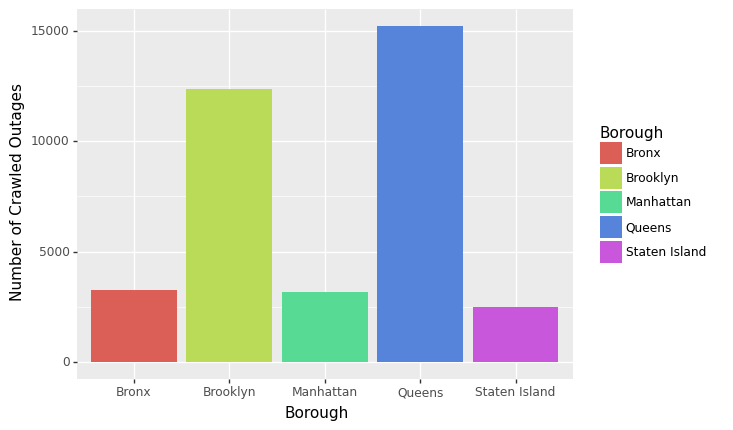

<ggplot: (8784176472820)>

In [56]:
ggplot(outages_b, aes('Borough', 'Count')) + \
geom_bar(aes(fill = 'Borough'), position = "dodge", stat="identity") + \
ylab('Number of Crawled Outages')

In [22]:
#borough_demo.reset_index(inplace = True)
borough_demo[['Borough', 'total_pop']]

,Borough,total_pop
0,Brooklyn,2531407
1,Manhattan,1554695
2,Queens,1545037
3,Staten Island,474893
4,The Bronx,1137085


In [23]:
outages_b['Borough'][outages_b['Borough'] == 'Bronx'] = 'The Bronx'
outages_b = outages_b.merge(borough_demo[['Borough', 'total_pop']], on = 'Borough')
outages_b

,Borough,Count,total_pop
0,The Bronx,3281,1137085
1,Brooklyn,12360,2531407
2,Manhattan,3180,1554695
3,Queens,15200,1545037
4,Staten Island,2514,474893


In [24]:
outages_b['outages_pp'] = outages_b['Count'] / outages_b['total_pop']
outages_b.head()

,Borough,Count,total_pop,outages_pp
0,The Bronx,3281,1137085,0.002885
1,Brooklyn,12360,2531407,0.004883
2,Manhattan,3180,1554695,0.002045
3,Queens,15200,1545037,0.009838
4,Staten Island,2514,474893,0.005294


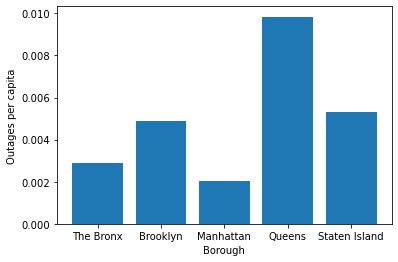

In [25]:
#ggplot(outages_b, aes('Borough', 'Count')) + \
#geom_bar(aes(), fill = 'dodgerblue', position = "dodge", stat="identity") + \
#ylab('Outages')

plt.bar(outages_b['Borough'],outages_b['outages_pp'])
plt.xlabel('Borough')
plt.ylabel('Outages per capita')
plt.rcParams["figure.figsize"] = (6,6)
plt.show()

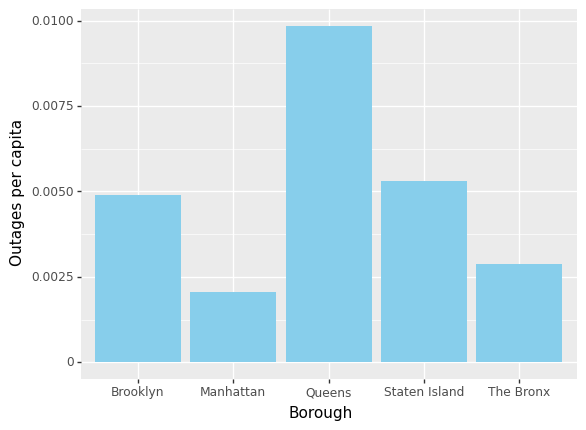

<ggplot: (8769799517281)>

In [26]:
ggplot(outages_b, aes('Borough', 'outages_pp')) + \
geom_bar(aes(), fill = 'skyblue', position = "dodge", stat="identity") + \
ylab('Outages per capita')

In [27]:
outages_zc['PostalCode'] = outages_zc['PostalCode'].astype(int)
demo['zip_code'] = demo['zip_code'].astype(int)

In [28]:
outages_zc = outages_zc.merge(demo[['zip_code', 'Borough', 'families_median_income','total_pop','non_white_perc']], 
                              left_on = 'PostalCode', right_on = 'zip_code')

In [29]:
outages_zc.rename(columns = {'Count': 'Outages'}, inplace = True)

In [30]:
outages_zc.head()

,PostalCode,Outages,zip_code,Borough,families_median_income,total_pop,non_white_perc
0,10001,75,10001,Manhattan,122776.0,24117,0.349961
1,10002,144,10002,Manhattan,40045.0,74479,0.679789
2,10003,155,10003,Manhattan,183787.0,53977,0.246327
3,10004,35,10004,Manhattan,205202.0,3335,0.390405
4,10006,12,10006,Manhattan,245764.0,3092,0.265201


In [31]:
outages_zc['outages_pp'] = outages_zc['Outages']/outages_zc['total_pop']
outages_zc.head()

,PostalCode,Outages,zip_code,Borough,families_median_income,total_pop,non_white_perc,outages_pp
0,10001,75,10001,Manhattan,122776.0,24117,0.349961,0.003110
1,10002,144,10002,Manhattan,40045.0,74479,0.679789,0.001933
2,10003,155,10003,Manhattan,183787.0,53977,0.246327,0.002872
3,10004,35,10004,Manhattan,205202.0,3335,0.390405,0.010495
4,10006,12,10006,Manhattan,245764.0,3092,0.265201,0.003881


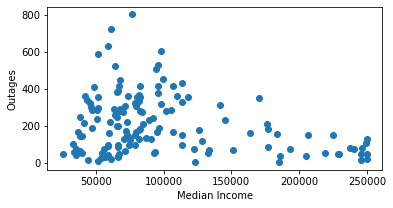

In [92]:
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(outages_zc['families_median_income'],outages_zc['Outages'])
plt.xlabel('Median Income')
plt.ylabel('Outages')
plt.show()

In [39]:
outages_zc['Borough'].unique()

array(['Manhattan', 'Staten Island', 'The Bronx', 'Queens', 'Brooklyn'],
      dtype=object)

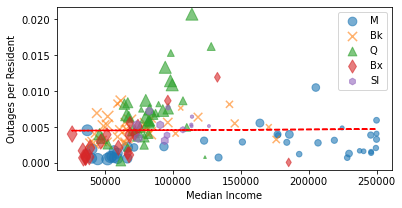

In [32]:
x = outages_zc['families_median_income']
y = outages_zc['outages_pp']
x1 = outages_zc[outages_zc['Borough']=='Manhattan']['families_median_income']
y1 = outages_zc[outages_zc['Borough']=='Manhattan']['outages_pp']
x2 = outages_zc[outages_zc['Borough']=='Brooklyn']['families_median_income']
y2 = outages_zc[outages_zc['Borough']=='Brooklyn']['outages_pp']
x3 = outages_zc[outages_zc['Borough']=='Queens']['families_median_income']
y3 = outages_zc[outages_zc['Borough']=='Queens']['outages_pp']
x4 = outages_zc[outages_zc['Borough']=='The Bronx']['families_median_income']
y4 = outages_zc[outages_zc['Borough']=='The Bronx']['outages_pp']
x5 = outages_zc[outages_zc['Borough']=='Staten Island']['families_median_income']
y5 = outages_zc[outages_zc['Borough']=='Staten Island']['outages_pp']
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(x1,y1,label='M', s=outages_zc[outages_zc['Borough']=='Manhattan']['non_white_perc']*150, alpha=.6 )
plt.scatter(x2,y2, marker='x',label='Bk', 
            s=outages_zc[outages_zc['Borough']=='Brooklyn']['non_white_perc']*150, alpha=.6)
plt.scatter(x3,y3, marker='^',label='Q', 
            s=outages_zc[outages_zc['Borough']=='Queens']['non_white_perc']*150, alpha=.6)
plt.scatter(x4,y4, marker = 'd',label='Bx', 
            s=outages_zc[outages_zc['Borough']=='The Bronx']['non_white_perc']*150, alpha=.6)
plt.scatter(x5,y5, marker='h', label='SI', 
            s=outages_zc[outages_zc['Borough']=='Staten Island']['non_white_perc']*150, alpha=.6)

plt.xlabel('Median Income')
plt.ylabel('Outages per Resident')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.legend()
plt.show()

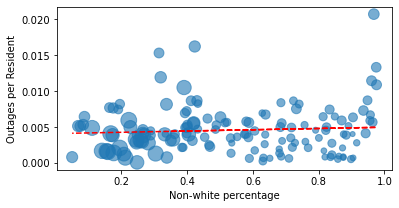

In [33]:
plt.scatter(outages_zc['non_white_perc'],outages_zc['outages_pp'],
            s=outages_zc['families_median_income']/1000, alpha=.6)
x = outages_zc['non_white_perc']
y = outages_zc['outages_pp']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.xlabel('Non-white percentage')
plt.ylabel('Outages per Resident')
plt.show()

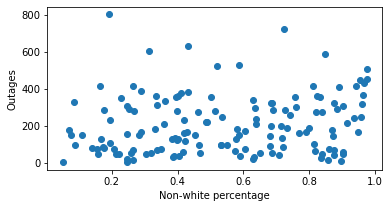

In [34]:
plt.scatter(outages_zc['non_white_perc'],outages_zc['Outages'])
plt.xlabel('Non-white percentage')
plt.ylabel('Outages')
plt.show()

In [35]:
outages_zc.sort_values('families_median_income', ascending = False).head(10)

,PostalCode,Outages,zip_code,Borough,families_median_income,total_pop,non_white_perc,outages_pp
38,10282,19,10282,Manhattan,250000.0,5783,0.244683,0.003285
17,10022,127,10022,Manhattan,250000.0,31130,0.167298,0.004080
5,10007,44,10007,Manhattan,250000.0,7408,0.222192,0.005940
8,10011,104,10011,Manhattan,249545.0,49949,0.194498,0.002082
19,10024,81,10024,Manhattan,246034.0,58102,0.176500,0.001394
35,10065,46,10065,Manhattan,246005.0,29530,0.158584,0.001558
4,10006,12,10006,Manhattan,245764.0,3092,0.265201,0.003881
16,10021,72,10021,Manhattan,240453.0,44280,0.155059,0.001626
23,10028,79,10028,Manhattan,237537.0,46768,0.140759,0.001689
7,10010,47,10010,Manhattan,229709.0,35906,0.303988,0.001309


In [36]:
outages_zc.sort_values('families_median_income').head(10)

,PostalCode,Outages,zip_code,Borough,families_median_income,total_pop,non_white_perc,outages_pp
68,10474,49,10474,The Bronx,25429.0,12179,0.903112,0.004023
56,10460,101,10460,The Bronx,33282.0,59432,0.815756,0.001699
52,10453,58,10453,The Bronx,33760.0,81716,0.904584,0.000710
51,10452,72,10452,The Bronx,35155.0,75452,0.861568,0.000954
53,10456,70,10456,The Bronx,35269.0,92717,0.874802,0.000755
55,10459,42,10459,The Bronx,35536.0,48780,0.874477,0.000861
30,10035,164,10035,Manhattan,36645.0,36048,0.790502,0.004549
54,10457,62,10457,The Bronx,38096.0,74822,0.819117,0.000829
78,11206,245,11206,Brooklyn,38430.0,88422,0.535602,0.002771
66,10472,142,10472,The Bronx,38655.0,67948,0.872432,0.002090


In [35]:
demo.head()

,zip_code,total_pop,white_pop,blackl_pop,native_american_pop,asian_pop,hispanic_pop,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,Borough,non_white_perc,families_median_income
0,10001,24117,15677,1510,16,5377,3741,0.650039,0.062611,0.000663,0.222955,0.155119,Manhattan,0.349961,122776.0
1,10002,74479,23849,6635,724,31198,19554,0.320211,0.089086,0.009721,0.418883,0.262544,Manhattan,0.679789,40045.0
2,10003,53977,40681,3007,81,7812,4559,0.753673,0.055709,0.001501,0.144728,0.084462,Manhattan,0.246327,183787.0
3,10004,3335,2033,142,0,992,108,0.609595,0.042579,0.000000,0.297451,0.032384,Manhattan,0.390405,205202.0
4,10006,3092,2272,99,0,496,335,0.734799,0.032018,0.000000,0.160414,0.108344,Manhattan,0.265201,245764.0


### Outages per Outage Type

In [37]:
outages_ot = outages.groupby('Cause').count()
outages_ot.reset_index(inplace=True)
outages_ot.rename(columns={'TimeCrawled':'Count'}, inplace=True)
outages_ot = outages_ot[['Cause', 'Count']]
outages_ot

,Cause,Count
0,Animal Contact With Equipment,12
1,Con Edison Equipment Damaged by Another Company,29
2,Emergency Repairs,276
3,Equipment Problem,331
4,Fallen Tree or Branches,142
5,Vehicle Collision Damaged Con Edison Pole,7
6,We'll provide details when we complete the inv...,19724
7,Weather-Related,16014


In [48]:
# Shortening Causes for readability
outages_ot.iloc[0,0] = 'Animal Interference'
outages_ot.iloc[1,0] = 'Equipment Damaged'
outages_ot.iloc[5,0] = 'Vehicle Collision w/ Pole'
outages_ot.iloc[6,0] = 'Still investigating'


In [82]:
#Increasing the count of other causes just for the visualization
outages_ot_viz = outages_ot.copy()
outages_ot_viz.iloc[0:6,1] = outages_ot_viz.iloc[0:6,1]+400
outages_ot_viz

,Cause,Count
0,Animal Interference,412
1,Equipment Damaged,429
2,Emergency Repairs,676
3,Equipment Problem,731
4,Fallen Tree or Branches,542
5,Vehicle Collision w/ Pole,407
6,Still investigating,19724
7,Weather-Related,16014


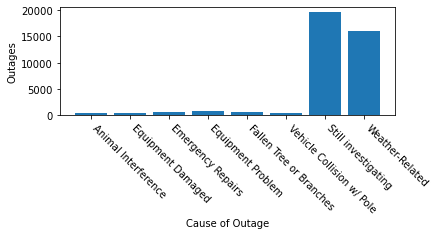

In [83]:
plt.rcParams["figure.figsize"] = (6,2)
plt.bar(outages_ot_viz['Cause'],outages_ot_viz['Count'])
#plt.pie(outages_ot['Count'], labels = outages_ot['Cause'])
plt.xlabel('Cause of Outage')
plt.ylabel('Outages')
plt.xticks(rotation = -45, ha='left')
plt.show()

In [30]:
outages['Problem'].unique()

array(['Partial Outage', 'No Lights', 'Area Outage', 'Burning Wires',
       'Building Outage', 'Service Wires Down', 'Wires Down',
       'Manhole Problem', 'MTA', 'Pole Damage'], dtype=object)

In [31]:
outages['Cause'].unique()

array(["We'll provide details when we complete the investigation.",
       'Emergency Repairs', 'Weather-Related', 'Equipment Problem',
       'Fallen Tree or Branches',
       'Con Edison Equipment Damaged by Another Company',
       'Vehicle Collision Damaged Con Edison Pole',
       'Animal Contact With Equipment'], dtype=object)

In [50]:
outages_bc = outages.groupby(['Borough','Cause']).count()
outages_bc.reset_index(inplace=True)
outages_bc = outages_bc[['Borough', 'Cause', 'TimeCrawled']]
outages_bc.rename(columns={'TimeCrawled':'Outages'}, inplace=True)
outages_bc = outages_bc[outages_bc['Cause']=='Weather-Related']

In [51]:
outages_bc

,Borough,Cause,Outages
5,Bronx,Weather-Related,202
12,Brooklyn,Weather-Related,7110
20,Manhattan,Weather-Related,816
27,Queens,Weather-Related,7768
35,Staten Island,Weather-Related,118


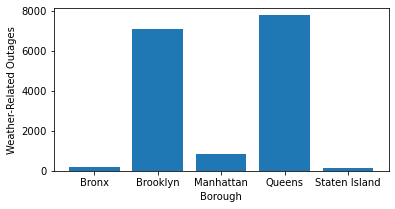

In [78]:
plt.rcParams["figure.figsize"] = (6,3)
plt.bar(outages_bc['Borough'],outages_bc['Outages'])
plt.xlabel('Borough')
plt.ylabel('Weather-Related Outages')

plt.show()

In [69]:
outages2 = outages.merge(demo[['zip_code', 'Borough', 'families_median_income','total_pop','non_white_perc']], 
                              left_on = 'PostalCode', right_on = 'zip_code')

In [70]:
outages2.head()

,GoogleMapsAddress,TimeCrawled,PostalCode,Latitude,Longitude,StreetNumber,StreetAddress,Neighborhood,Borough_x,County,...,Cause,UniqueID,DateCrawled,TimeStampCrawled,DateFixed,zip_code,Borough_y,families_median_income,total_pop,non_white_perc
0,53 GAULDY AV,00:56:09,10314.0,40.618659,-74.165248,53,Gauldy Avenue,Bulls Head,Staten Island,Richmond County,...,We'll provide details when we complete the inv...,1,2021-09-18 00:00:00.000,1.631927e+09,2021-09-18 05:06:22.473,10314,Staten Island,107154.0,89792,0.265235
1,75 RIDGEWAY DR,02:22:07,10314.0,40.595367,-74.183151,75,Ridgeway Avenue,Travis - Chelsea,Staten Island,Richmond County,...,We'll provide details when we complete the inv...,1,2021-09-16 00:00:00.000,1.631759e+09,2021-09-16 13:59:39.303,10314,Staten Island,107154.0,89792,0.265235
2,72 RIDGEWAY DR,02:22:06,10314.0,40.595371,-74.183156,72,Ridgeway Avenue,Travis - Chelsea,Staten Island,Richmond County,...,We'll provide details when we complete the inv...,1,2021-09-16 00:00:00.000,1.631759e+09,2021-09-16 13:59:39.283,10314,Staten Island,107154.0,89792,0.265235
3,67 RIDGEWAY DR,02:22:01,10314.0,40.595383,-74.183172,67,Ridgeway Avenue,Travis - Chelsea,Staten Island,Richmond County,...,We'll provide details when we complete the inv...,1,2021-09-16 00:00:00.000,1.631759e+09,2021-09-16 13:59:39.257,10314,Staten Island,107154.0,89792,0.265235
4,65 RIDGEWAY DR,02:22:04,10314.0,40.594923,-74.182319,65,Ridgeway Avenue,Travis - Chelsea,Staten Island,Richmond County,...,We'll provide details when we complete the inv...,1,2021-09-16 00:00:00.000,1.631759e+09,2021-09-16 13:59:39.247,10314,Staten Island,107154.0,89792,0.265235


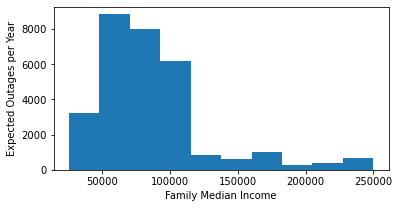

In [76]:
plt.hist(outages2['families_median_income'])
plt.xlabel('Family Median Income')
plt.ylabel('Expected Outages per Year')
plt.show()

In [74]:
outages2['DateCrawled'].min()

'2020-10-04 00:00:00.000'

In [75]:
outages2['DateCrawled'].max()

'2021-09-18 00:00:00.000'

In [77]:
demo.head()

,zip_code,total_pop,white_pop,blackl_pop,native_american_pop,asian_pop,hispanic_pop,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,Borough,non_white_perc,families_median_income
0,10001,24117,15677,1510,16,5377,3741,0.650039,0.062611,0.000663,0.222955,0.155119,Manhattan,0.349961,122776.0
1,10002,74479,23849,6635,724,31198,19554,0.320211,0.089086,0.009721,0.418883,0.262544,Manhattan,0.679789,40045.0
2,10003,53977,40681,3007,81,7812,4559,0.753673,0.055709,0.001501,0.144728,0.084462,Manhattan,0.246327,183787.0
3,10004,3335,2033,142,0,992,108,0.609595,0.042579,0.000000,0.297451,0.032384,Manhattan,0.390405,205202.0
4,10006,3092,2272,99,0,496,335,0.734799,0.032018,0.000000,0.160414,0.108344,Manhattan,0.265201,245764.0


In [38]:
households = pd.read_csv('Income_demo_poverty_data/nyc_households.csv')

In [40]:
households2 = households.iloc[:,1:].shift(periods=-1)

In [41]:
households2['label'] = households['Label (Grouping)']

In [42]:
households2.dropna(inplace=True)

In [43]:
labels = households2['label'].str.split(' ')
labels = labels[:-1]
labels = [int(x[1]) for x in labels]

In [44]:
households2.drop(index = 432, inplace=True)

In [45]:
households2['label'] = labels
households2.rename(columns={'label':'PostalCode', 'Total:':'Households'},inplace=True)
households2.head()

,Households,Total:!!Owner occupied,Total:!!Renter occupied,PostalCode
0,"58,791","22,122","36,669",11201
2,"74,209","33,224","40,985",11203
4,"76,273","31,021","45,252",11204
6,"44,402","11,857","32,545",11205
8,"87,747","11,101","76,646",11206


In [46]:
outages_zc = outages_zc.merge(households2[['Households', 'PostalCode']], on = 'PostalCode', how='left')

In [48]:
outages_zc['Households'] = outages_zc['Households'].str.replace(',','')
outages_zc.iloc[70, 8] = 4261
outages_zc['Households'] = outages_zc['Households'].astype(int)
outages_zc['outages_ph'] = outages_zc['Outages']/outages_zc['Households']

In [49]:
outages_zc['outages_th'] = outages_zc['Outages']*outages_zc['Households']

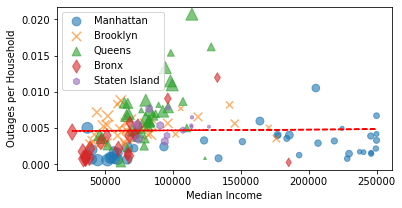

In [51]:
x = outages_zc['families_median_income']
y = outages_zc['outages_ph']
x1 = outages_zc[outages_zc['Borough']=='Manhattan']['families_median_income']
y1 = outages_zc[outages_zc['Borough']=='Manhattan']['outages_ph']
x2 = outages_zc[outages_zc['Borough']=='Brooklyn']['families_median_income']
y2 = outages_zc[outages_zc['Borough']=='Brooklyn']['outages_ph']
x3 = outages_zc[outages_zc['Borough']=='Queens']['families_median_income']
y3 = outages_zc[outages_zc['Borough']=='Queens']['outages_ph']
x4 = outages_zc[outages_zc['Borough']=='The Bronx']['families_median_income']
y4 = outages_zc[outages_zc['Borough']=='The Bronx']['outages_ph']
x5 = outages_zc[outages_zc['Borough']=='Staten Island']['families_median_income']
y5 = outages_zc[outages_zc['Borough']=='Staten Island']['outages_ph']
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(x1,y1,label='Manhattan', s=outages_zc[outages_zc['Borough']=='Manhattan']['non_white_perc']*150, alpha=.6 )
plt.scatter(x2,y2, marker='x',label='Brooklyn', 
            s=outages_zc[outages_zc['Borough']=='Brooklyn']['non_white_perc']*150, alpha=.6)
plt.scatter(x3,y3, marker='^',label='Queens', 
            s=outages_zc[outages_zc['Borough']=='Queens']['non_white_perc']*150, alpha=.6)
plt.scatter(x4,y4, marker = 'd',label='Bronx', 
            s=outages_zc[outages_zc['Borough']=='The Bronx']['non_white_perc']*150, alpha=.6)
plt.scatter(x5,y5, marker='h', label='Staten Island', 
            s=outages_zc[outages_zc['Borough']=='Staten Island']['non_white_perc']*150, alpha=.6)

plt.xlabel('Median Income')
plt.ylabel('Outages per Household')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.legend()
plt.show()

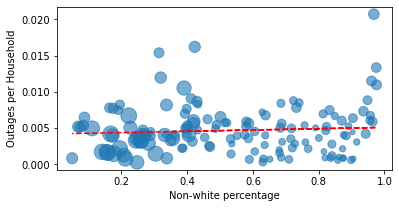

In [189]:
plt.scatter(outages_zc['non_white_perc'],outages_zc['outages_ph'],
            s=outages_zc['families_median_income']/1000, alpha=.6)
x = outages_zc['non_white_perc']
y = outages_zc['outages_ph']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.xlabel('Non-white percentage')
plt.ylabel('Outages per Household')
plt.legend()
plt.show()

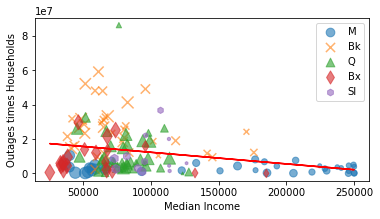

In [54]:
x = outages_zc['families_median_income']
y = outages_zc['outages_th']
x1 = outages_zc[outages_zc['Borough']=='Manhattan']['families_median_income']
y1 = outages_zc[outages_zc['Borough']=='Manhattan']['outages_th']
x2 = outages_zc[outages_zc['Borough']=='Brooklyn']['families_median_income']
y2 = outages_zc[outages_zc['Borough']=='Brooklyn']['outages_th']
x3 = outages_zc[outages_zc['Borough']=='Queens']['families_median_income']
y3 = outages_zc[outages_zc['Borough']=='Queens']['outages_th']
x4 = outages_zc[outages_zc['Borough']=='The Bronx']['families_median_income']
y4 = outages_zc[outages_zc['Borough']=='The Bronx']['outages_th']
x5 = outages_zc[outages_zc['Borough']=='Staten Island']['families_median_income']
y5 = outages_zc[outages_zc['Borough']=='Staten Island']['outages_th']
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(x1,y1,label='M', s=outages_zc[outages_zc['Borough']=='Manhattan']['non_white_perc']*150, alpha=.6 )
plt.scatter(x2,y2, marker='x',label='Bk', 
            s=outages_zc[outages_zc['Borough']=='Brooklyn']['non_white_perc']*150, alpha=.6)
plt.scatter(x3,y3, marker='^',label='Q', 
            s=outages_zc[outages_zc['Borough']=='Queens']['non_white_perc']*150, alpha=.6)
plt.scatter(x4,y4, marker = 'd',label='Bx', 
            s=outages_zc[outages_zc['Borough']=='The Bronx']['non_white_perc']*150, alpha=.6)
plt.scatter(x5,y5, marker='h', label='SI', 
            s=outages_zc[outages_zc['Borough']=='Staten Island']['non_white_perc']*150, alpha=.6)

plt.xlabel('Median Income')
plt.ylabel('Outages times Households')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.legend()
plt.show()

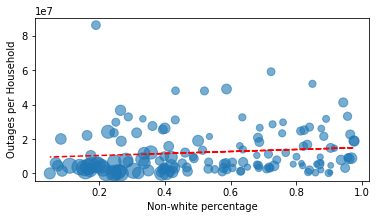

In [193]:
plt.scatter(outages_zc['non_white_perc'],outages_zc['outages_th'],
            s=outages_zc['families_median_income']/1000, alpha=.6)
x = outages_zc['non_white_perc']
y = outages_zc['outages_th']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.xlabel('Non-white percentage')
plt.ylabel('Outages times Households')
plt.show()

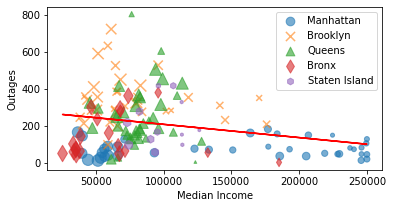

In [56]:
x = outages_zc['families_median_income']
y = outages_zc['Outages']
x1 = outages_zc[outages_zc['Borough']=='Manhattan']['families_median_income']
y1 = outages_zc[outages_zc['Borough']=='Manhattan']['Outages']
x2 = outages_zc[outages_zc['Borough']=='Brooklyn']['families_median_income']
y2 = outages_zc[outages_zc['Borough']=='Brooklyn']['Outages']
x3 = outages_zc[outages_zc['Borough']=='Queens']['families_median_income']
y3 = outages_zc[outages_zc['Borough']=='Queens']['Outages']
x4 = outages_zc[outages_zc['Borough']=='The Bronx']['families_median_income']
y4 = outages_zc[outages_zc['Borough']=='The Bronx']['Outages']
x5 = outages_zc[outages_zc['Borough']=='Staten Island']['families_median_income']
y5 = outages_zc[outages_zc['Borough']=='Staten Island']['Outages']
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(x1,y1,label='Manhattan', s=outages_zc[outages_zc['Borough']=='Manhattan']['non_white_perc']*150, alpha=.6 )
plt.scatter(x2,y2, marker='x',label='Brooklyn', 
            s=outages_zc[outages_zc['Borough']=='Brooklyn']['non_white_perc']*150, alpha=.6)
plt.scatter(x3,y3, marker='^',label='Queens', 
            s=outages_zc[outages_zc['Borough']=='Queens']['non_white_perc']*150, alpha=.6)
plt.scatter(x4,y4, marker = 'd',label='Bronx', 
            s=outages_zc[outages_zc['Borough']=='The Bronx']['non_white_perc']*150, alpha=.6)
plt.scatter(x5,y5, marker='h', label='Staten Island', 
            s=outages_zc[outages_zc['Borough']=='Staten Island']['non_white_perc']*150, alpha=.6)

plt.xlabel('Median Income')
plt.ylabel('Outages')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.legend()
plt.show()

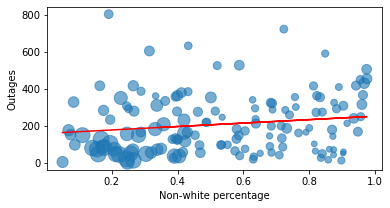

In [200]:
plt.scatter(outages_zc['non_white_perc'],outages_zc['Outages'],
            s=outages_zc['families_median_income']/1000, alpha=.6)
x = outages_zc['non_white_perc']
y = outages_zc['Outages']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.xlabel('Non-white percentage')
plt.ylabel('Outages')
plt.show()

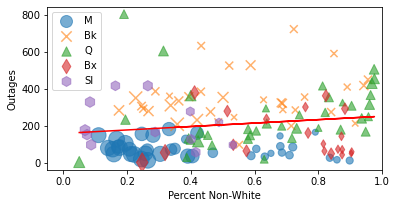

In [67]:
x = outages_zc['non_white_perc']
y = outages_zc['Outages']
x1 = outages_zc[outages_zc['Borough']=='Manhattan']['non_white_perc']
y1 = outages_zc[outages_zc['Borough']=='Manhattan']['Outages']
x2 = outages_zc[outages_zc['Borough']=='Brooklyn']['non_white_perc']
y2 = outages_zc[outages_zc['Borough']=='Brooklyn']['Outages']
x3 = outages_zc[outages_zc['Borough']=='Queens']['non_white_perc']
y3 = outages_zc[outages_zc['Borough']=='Queens']['Outages']
x4 = outages_zc[outages_zc['Borough']=='The Bronx']['non_white_perc']
y4 = outages_zc[outages_zc['Borough']=='The Bronx']['Outages']
x5 = outages_zc[outages_zc['Borough']=='Staten Island']['non_white_perc']
y5 = outages_zc[outages_zc['Borough']=='Staten Island']['Outages']
plt.rcParams["figure.figsize"] = (6,3)
plt.scatter(x1,y1,label='M', s=outages_zc[outages_zc['Borough']=='Manhattan']['families_median_income']/1000, 
            alpha=.6 )
plt.scatter(x2,y2, marker='x',label='Bk', 
            s=outages_zc[outages_zc['Borough']=='Brooklyn']['families_median_income']/1000, alpha=.6)
plt.scatter(x3,y3, marker='^',label='Q', 
            s=outages_zc[outages_zc['Borough']=='Queens']['families_median_income']/1000, alpha=.6)
plt.scatter(x4,y4, marker = 'd',label='Bx', 
            s=outages_zc[outages_zc['Borough']=='The Bronx']['families_median_income']/1000, alpha=.6)
plt.scatter(x5,y5, marker='h', label='SI', 
            s=outages_zc[outages_zc['Borough']=='Staten Island']['families_median_income']/1000, alpha=.6)

plt.xlabel('Percent Non-White')
plt.ylabel('Outages')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")
plt.legend(loc='upper left')
plt.xlim(-.05, 1)
plt.show()